Тестовое задание
================

In [52]:
import re
from typing import Dict, List
from matplotlib import pyplot
import sqlite3
import pandas
import math
import numpy

In [53]:
pandas.set_option("display.max_columns", 30)

## SQL

В *SQLite* файле `issues.db` находится таблица `history`.

Таблица содержит следующие колонки:
* `issue_key` – уникальный ключ задачи
* `status` – статус задачи
* `minutes_in_status` – количество минут, которое задача находилась в статусе
* `previous_status` – предыдущий статус задачи
* `status_begin` – время перехода задачи в текущий статус
* `status_end` – время окончания нахождения задачи в текущем статусе

Время `status_begin` и `ended_at` указаны в формате unix epoch в *миллисекундах*.

### Задача 1

Напишите SQL запрос, который для всех задач, открытых на момент времени `T`, выведет:
* ключ задачи
* время создания задачи
* статус на момент `T`

Задача считается открытой на момент времени `T`, если к этому времени последний статус задачи был любой кроме `Closed` и `Resolved`.

Оформите запрос таким образом, чтобы, изменив дату, его можно было использовать для поиска открытых задач в любой момент времени как в прошлом, так и в настоящем.

Здесь и далее все даты и времена должны быть переведены в удобочитаемый вид.

In [54]:
connection = sqlite3.connect("issues.db")

In [55]:
query_resultset = connection.execute(
    """
        select issue_key, status, datetime(round(status_begin / 1000), 'unixepoch') from history
        group by issue_key
        having max(datetime(round(status_begin / 1000), 'unixepoch')) <= datetime('now')
        and status not in ('Closed', 'Resolved')
    """
).fetchall()

for result in query_resultset:
    print(result)

('A-31053', 'Open', '2020-10-21 15:08:13')
('A-32133', 'Open', '2021-04-29 09:55:29')
('A-37761', 'In Owl', '2022-12-28 08:18:46')
('A-42030', 'Open', '2022-09-01 15:04:15')
('A-44107', 'In Owl', '2022-12-26 18:31:23')
('A-44901', 'In Owl', '2022-12-27 12:11:12')
('A-44916', 'Blocked', '2022-09-15 09:17:04')
('A-47808', 'Reopened', '2022-10-31 08:54:08')
('A-49140', 'Reopened', '2022-12-29 11:03:37')
('A-49829', 'In Review', '2022-10-20 10:13:04')
('A-50359', 'In Owl', '2022-11-15 06:51:48')
('A-50422', 'In Testing', '2022-11-01 11:56:49')
('A-51466', 'Waiting for integration', '2022-11-14 12:42:43')
('A-52727', 'Waiting for integration', '2022-12-27 12:11:11')
('A-52884', 'Blocked', '2022-11-28 15:12:43')
('A-53409', 'Waiting for integration', '2022-12-12 15:08:39')
('A-53444', 'Open', '2022-12-07 09:19:27')
('A-53602', 'Waiting for integration', '2022-12-26 13:03:29')
('A-53676', 'Waiting for integration', '2022-12-26 18:31:22')
('A-54115', 'Open', '2022-12-20 17:57:23')
('A-54133', 

In [56]:
connection.close()

## Pandas

Файл `task_history.csv` содержит исторические данные системы сборки (e.g. *jenkins*, *teamcity*, etc.)

Каждая запись в истории описывает отдельный запуск задачи `build_name` на рабочей машине `worker`.<br/>
Для любого запуска известны автор `author` и проект `project`, в рамках которого был запущен расчет данной задачи.

In [57]:
task_history = pandas.read_csv("task_history.csv")

task_history.head()

,task_id,start_time,finish_time,status,worker,build_name,author,project
0,44973,2005-06-26 09:05:45.716,2005-06-26 09:05:45.997,success,worker_00,test_cyan_texture,Kenny Smith,Halo Anniversary
1,44974,2005-06-26 09:05:46.200,2005-06-26 09:05:46.497,success,worker_01,test_cyan_texture,Kenny Smith,Halo Anniversary
2,44975,2005-06-26 09:05:47.357,2005-06-26 09:06:01.213,success,worker_02,test_cyan_texture,Kenny Smith,Halo Anniversary
3,44977,2005-06-26 09:06:19.273,2005-06-26 09:10:44.734,success,worker_02,test_cyan_texture,Kenny Smith,Halo Anniversary
4,44979,2005-06-26 09:12:00.883,2005-06-26 09:14:29.941,success,worker_04,test_cyan_texture,Kenny Smith,Halo Anniversary


### Задача 2

Для каждой недели распечатайте топ-3 пользователей, потребивших наибольшее количество машиночасов (количество часов, затраченных машиной на обработку задачи).

Выведите для данных пользователей процент потребленных ресурсов от общего объема расчетов за эту неделю.

In [58]:
days_of_year_of_task_beginning = pandas.to_datetime(task_history["start_time"]).dt.day_of_year
days_of_year_of_task_finishing = pandas.to_datetime(task_history["finish_time"]).dt.day_of_year

weeks_of_task_beginning = pandas.to_datetime(task_history["start_time"]).dt.isocalendar().week
weeks_of_task_finishing = pandas.to_datetime(task_history["finish_time"]).dt.isocalendar().week

map_of_days_and_weeks_of_task_beginning = {day: week for day, week in zip(days_of_year_of_task_beginning, weeks_of_task_beginning)}
map_of_days_and_weeks_of_task_finishing = {day: week for day, week in zip(days_of_year_of_task_finishing, weeks_of_task_finishing)}

map_of_days_and_weeks = dict(sorted({**map_of_days_and_weeks_of_task_beginning, **map_of_days_and_weeks_of_task_finishing}.items()))

task_history = task_history.reindex(task_history.columns.to_list() + [f"resource_usage_for_day{day}" for day in map_of_days_and_weeks.keys()], axis=1)

for (index, task), day_of_year_of_task_beginning, day_of_year_of_task_finishing in zip(task_history.iterrows(), days_of_year_of_task_beginning, days_of_year_of_task_finishing):
    date_of_task_beginning = pandas.Timestamp(task['start_time'])
    date_of_task_finishing = pandas.Timestamp(task['finish_time'])
    if day_of_year_of_task_beginning == day_of_year_of_task_finishing:
        build_time: pandas.Timedelta = date_of_task_finishing - date_of_task_beginning
        task_history.at[index, f"resource_usage_for_day{day_of_year_of_task_beginning}"] = build_time.seconds
    else:
        next_day = pandas.Timestamp(year=date_of_task_finishing.year, month=date_of_task_finishing.month, day=date_of_task_finishing.day)
        build_time_for_day_of_task_beginning: pandas.Timedelta = next_day - date_of_task_beginning
        build_time_for_day_of_task_finishing: pandas.Timedelta = date_of_task_finishing - next_day

        task_history.at[index, f"resource_usage_for_day{day_of_year_of_task_beginning}"] = build_time_for_day_of_task_beginning.seconds
        task_history.at[index, f"resource_usage_for_day{day_of_year_of_task_finishing}"] = build_time_for_day_of_task_finishing.seconds

In [59]:
weeks : List[int] = list(set(weeks_of_task_beginning).union(set(weeks_of_task_finishing)))

authors : List[str] = task_history["author"].unique()

resource_usage_by_each_author_per_week: Dict[int, Dict[str, int]] = {week: {author: 0 for author in authors} for week in weeks}

for day_of_year, week in map_of_days_and_weeks.items():
    label_of_day_of_year = f"resource_usage_for_day{day_of_year}"
    task_history_grouped_by_author = task_history[task_history[label_of_day_of_year].notna()].groupby("author")

    resource_usage_per_day_of_year_and_author = task_history_grouped_by_author[label_of_day_of_year].sum()
    
    for author in task_history_grouped_by_author.groups.keys():
        resource_usage_by_each_author_per_week[week][author] += resource_usage_per_day_of_year_and_author[author]

for week, usages in resource_usage_by_each_author_per_week.items():
    sorted_usages = list(dict(sorted(usages.items(), key=lambda usage : usage[1], reverse=True)).items())
    
    total_build_time_per_week = 0
    for author, usage in sorted_usages:
        total_build_time_per_week += usage
    print(f"Week:{week}.")
    for author, usage in sorted_usages[:3]:
        print(f"Usage: {int(usage * 100 // total_build_time_per_week)}%. User: {author}.")

Week:25.
Usage: 45%. User: Bendy Python.
Usage: 4%. User: Marsha Koltron.
Usage: 2%. User: Java Smoozy.
Week:26.
Usage: 38%. User: Bendy Python.
Usage: 6%. User: Marsha Koltron.
Usage: 4%. User: John Ivanov.
Week:27.
Usage: 40%. User: Bendy Python.
Usage: 5%. User: Java Smoozy.
Usage: 3%. User: Eric Smith.
Week:28.
Usage: 45%. User: Bendy Python.
Usage: 4%. User: Kenny Ivanov.
Usage: 3%. User: John Kotlin.
Week:29.
Usage: 75%. User: Bendy Python.
Usage: 15%. User: John Koltron.
Usage: 4%. User: John Ivanov.


### Задача 3

Отобразите график с ежедневным потреблением машинного времени каждым проектом.

In [60]:
days_of_year = list(map_of_days_and_weeks.keys())

resource_usage_by_each_project_per_day_of_year = []
for day_of_year in days_of_year:
    resource_usage_for_day_of_year = f"resource_usage_for_day{day_of_year}"
    task_history_filtered_from_na = task_history[task_history[resource_usage_for_day_of_year].notna()]
    resource_usage_per_day_of_year = task_history_filtered_from_na.groupby("project")[resource_usage_for_day_of_year].sum() / 3600
    resource_usage_by_each_project_per_day_of_year.append(resource_usage_per_day_of_year.values)

resource_usage_by_each_project = numpy.reshape(
    resource_usage_by_each_project_per_day_of_year,
    (
    len(resource_usage_by_each_project_per_day_of_year[0]),
    len(resource_usage_by_each_project_per_day_of_year)
    )
)

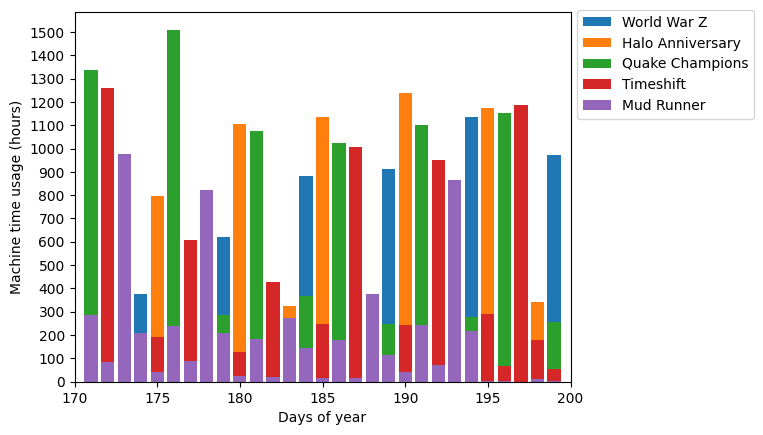

In [61]:
project_names = list(set(task_history.groupby("project").groups.keys()))

x = map_of_days_and_weeks
y = resource_usage_by_each_project

figure, axis = pyplot.subplots()

for i, project_name in enumerate(project_names):
    axis.bar(days_of_year, resource_usage_by_each_project[i], label=project_name)

pyplot.legend(bbox_to_anchor=(1.0, 1.025), loc="upper left")
pyplot.ticklabel_format(style="plain")
pyplot.yticks(numpy.arange(0, numpy.max(resource_usage_by_each_project), 100))
pyplot.ylabel("Machine time usage (hours)")
pyplot.xlim((days_of_year[0] - 1, days_of_year[len(days_of_year) - 1] + 1))
pyplot.xlabel("Days of year")

pyplot.show()

### Задача 4

Рассмотрим *еженедельное* общее потребление ресурсов. На второй неделе можно заметить всплеск нагрузки с ее последующим планомерным снижением.

Проанализируйте предоставленные данные и найдите, с чем связано подобное поведение.

In [62]:
tasks_per_week: Dict[int, int] = {week_number: 0 for week_number in weeks}

for day_of_year, week in map_of_days_and_weeks.items():
    label_of_day_of_year = f"resource_usage_for_day{day_of_year}"
    
    task_history_filtered_from_na = task_history[task_history[label_of_day_of_year].notna()]

    tasks_per_day_of_year = task_history_filtered_from_na["build_name"].count()
    tasks_per_week[week] += tasks_per_day_of_year

for week, tasks in tasks_per_week.items():
    print(f"Week: {week}. Number of tasks: {tasks}")

Week: 25. Number of tasks: 37416
Week: 26. Number of tasks: 39812
Week: 27. Number of tasks: 42833
Week: 28. Number of tasks: 42021
Week: 29. Number of tasks: 45


In [63]:
builds_per_week: Dict[int, int] = {week_number: 0 for week_number in weeks}

for day_of_year, week in map_of_days_and_weeks.items():
    label_of_day_of_year = f"resource_usage_for_day{day_of_year}"
    
    task_history_filtered_from_na = task_history[task_history[label_of_day_of_year].notna()]

    builds_per_day_of_year = task_history_filtered_from_na["build_name"].where(lambda build_names: build_names.str.startswith("build_")).count()
    builds_per_week[week] += builds_per_day_of_year

for week, deploys, tasks in zip(weeks, builds_per_week.values(), tasks_per_week.values()):
    print(f"Week: {week}. Builds: {(deploys * 100) // tasks}%.")

Week: 25. Builds: 36%.
Week: 26. Builds: 38%.
Week: 27. Builds: 36%.
Week: 28. Builds: 34%.
Week: 29. Builds: 26%.


In [64]:
build_costs_by_each_project_per_day_of_year = {week: 0 for week in map_of_days_and_weeks.values()}

for day_of_year, week in map_of_days_and_weeks.items():
    resource_usage_for_day_of_year = f"resource_usage_for_day{day_of_year}"
    
    task_history_filtered_from_na = task_history[task_history[resource_usage_for_day_of_year].notna()]
    
    build_costs_per_day_of_year = task_history_filtered_from_na[task_history_filtered_from_na.apply(lambda task: task["build_name"].startswith("build_"), axis=1)][resource_usage_for_day_of_year].sum() // 3600
    build_costs_by_each_project_per_day_of_year[week] += build_costs_per_day_of_year

print(build_costs_by_each_project_per_day_of_year)

{25: 4584.0, 26: 6675.0, 27: 5335.0, 28: 4300.0, 29: 5.0}


Из того, что успел проанализировать: на второй неделе наблюдается рост количества задач связанных именно со сборкой проекта. 

В то же время в среднем сборка является самой ресурсозатратной задачей из представленных, что и обсуславливает скачек нагрузки.